In [23]:
%matplotlib inline
# %matplotlib widget # 跟圖互動，可以用點選圖片中的某位置觸發程式
%env KERAS_BACKEND=tensorflow
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
# from matplotlib.widgets import Cursor, Button
from ipywidgets import interact, IntSlider, Button
from ipywidgets import interact_manual
import IPython.display as ipd
import networkx as nx # draw graph vertex & edge
import pydub # audio
from numpy.fft import fft, ifft # , irfft, rfft # fourier transform
# import sympy as sym
# from sympy import S,N
# import locale # 資料處理 轉換數字格式

# from sklearn.linear_model import LinearRegression
# from keras.utils import np_utils #one hot encoding
# from keras.models import Sequential #神經網路的框架keras.models
from keras.layers import Dense, Activation, Embedding
# from keras.layers import LSTM
from keras.layers import Flatten # 將資料展平
# from keras.layers import Conv2D, MaxPool2D, MaxPooling2D
from keras.layers import Conv1D, MaxPool1D, MaxPooling1D
from keras.optimizers import SGD, Adadelta, Adam
from keras.models import model_from_json
# from keras.datasets import mnist # mnist內 包含手寫測試資料
# from keras.datasets import imdb # imdb內 包含電影評論資料
# from keras.preprocessing import sequence # 用來同整不同長度的電影評論，多的擷掉，少的補 0
# from keras.preprocessing.text import Tokenizer # 轉換文字成數字
# from sklearn.model_selection import train_test_split

#for Functional API
from keras.models import Model
from keras.layers import Input
from keras.layers import concatenate, add
# #for Functional API transfer learning
from keras.layers.core import Lambda
from keras import backend as K

# from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dropout

# import matplotlib.image as mpimg #import image file

env: KERAS_BACKEND=tensorflow


In [2]:
# import IPython.display as ipd
def playAudio(x, rate = 0):
    if type(x)!=np.ndarray:
        ipd.display(ipd.Audio(x))
    elif rate == 0:
        print("input rate!")
        return
    elif len(x.shape) > 1:
        ipd.display(ipd.Audio(x.T.astype(int), rate = rate))
    else:
        ipd.display(ipd.Audio(x.astype(int), rate = rate))

def read(f, normalized=False):
    """MP3 to numpy array"""
    a = pydub.AudioSegment.from_mp3(f)
    y = np.array(a.get_array_of_samples())
    if a.channels == 2:
        y = y.reshape((-1, 2))
    if normalized:
        return a.frame_rate, np.float32(y) / 2**15
    else:
        return a.frame_rate, y

def write(f, sr, x, normalized=False):
    """numpy array to MP3"""
    channels = 2 if (x.ndim == 2 and x.shape[1] == 2) else 1
    if normalized:  # normalized array - each item should be a float in [-1, 1)
        y = np.int16(x * 2 ** 15)
    else:
        y = np.int16(x)
    song = pydub.AudioSegment(y.tobytes(), frame_rate=sr, sample_width=2, channels=channels)
    song.export(f, format="mp3", bitrate="320k")

In [3]:
###################### skip ######################
# import pydub
# from pydub.playback import play
# pydub.AudioSegment.converter = "C:\\FFmpeg\\ffmpeg-20190604-d81913e-win64-static\\bin\\ffmpeg.exe"

# song = pydub.AudioSegment.from_mp3("jazz.mp3")

# play(song)
# pydub.playback(song)
###################### skip ######################

In [4]:
# out_array = song_array[:int(len(song_array)/10)]/100
# write('out.mp3', rate, out_array, normalized=False)

In [5]:
# playAudio('out.mp3') # ipd.Audio('out.mp3')
# playAudio(out_array, rate = rate) # ipd.Audio(out_array.T, rate = rate) # ipd.Audio(out_array[:,1], rate = rate)

In [6]:
# sr = 22050 # sample rate
# T = 2.0    # seconds
# t = np.linspace(0, T, int(T*sr), endpoint=False) # time variable
# x = 0.5 * np.sin(2*np.pi*440*t)
# playAudio(x, rate=sr) # ipd.Audio(x, rate = sr)

#### setting training data

In [7]:
rate, song_array = read('jazz.mp3', normalized=False)
print("frame_rate = ", rate, "(每秒鐘會產生", rate, "長度的陣列)\nsong_array = \n", song_array)
print("song_array.shape = ", song_array.shape)
chennel_length = 2
segement_length_sec = 2
segement_length = segement_length_sec * rate
train0 = song_array[0:segement_length * (song_array.shape[0]//segement_length)].copy()
train0 = train0.reshape(-1, segement_length, chennel_length).astype(float)
max_value = np.max(train0.reshape(-1))
min_value = np.min(train0.reshape(-1))
def normalize(data, max_value, min_value):
    data = data - min_value
    data = data / (max_value - min_value)
    return data
def inverse_normalize(data, max_value, min_value):
    data = data * (max_value - min_value)
    data = data + min_value
    return data
train0 = normalize(train0, max_value, min_value)

print("There are", train0.shape[0], "segements in train0.")
print("\ntrain0[87] = ", train0[87])

frame_rate =  48000 (每秒鐘會產生 48000 長度的陣列)
song_array = 
 [[  0   0]
 [  0   0]
 [  0   0]
 ...
 [-40 -62]
 [-24 -54]
 [  1 -20]]
song_array.shape =  (86401152, 2)
There are 900 segements in train0.

train0[87] =  [[0.49777981 0.46565957]
 [0.48760204 0.46366064]
 [0.42873274 0.4152285 ]
 ...
 [0.40015259 0.44693675]
 [0.41074235 0.47539483]
 [0.41205463 0.46970321]]


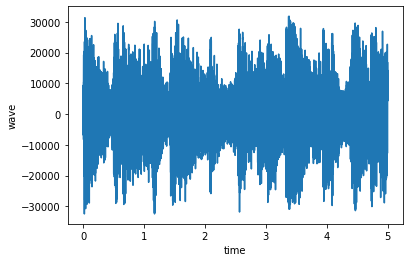

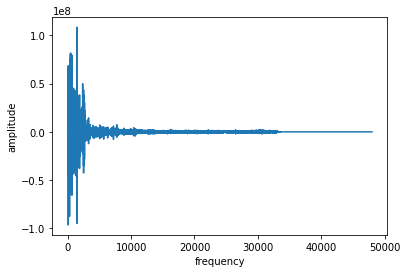

In [9]:
aud_data = song_array[segement_length*23:segement_length*24, 0].copy()

len_data = len(aud_data)
channel_1 = np.zeros(2**(int(np.ceil(np.log2(len_data)))))
channel_1[0:len_data] = aud_data
fourier = fft(channel_1)
t = np.linspace(0, segement_length_sec, len_data)
w = np.linspace(0, rate, len(fourier)//2)
fourier_to_plot = fourier[0:len(fourier)//2].real

plt.figure(1)
plt.plot(t, aud_data, label='aud_data')
plt.xlabel('time')
plt.ylabel('wave')
plt.figure(2)
plt.plot(w, fourier_to_plot, label='fourier_to_plot')
plt.xlabel('frequency')
plt.ylabel('amplitude')
plt.show()

#### modeling

In [8]:
rate = 48000
chennel_length = 2
segement_length_sec = 2
segement_length = segement_length_sec * rate


x = Input(shape = (3,), name='generator_x')
# z = concatenate([x, z], name='concatenate1')
# z = Flatten()(z)
z = Dense(segement_length * chennel_length //10000, activation='selu', name='generator_d1')(x)
z = Dense(segement_length * chennel_length //100, activation='selu', name='generator_d2')(z)
fake = Dense(segement_length * chennel_length, activation='softmax', name='generator_fake')(z)

Instructions for updating:
Colocations handled automatically by placer.


In [9]:
generator = Model(x, fake)
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
generator_x (InputLayer)     (None, 3)                 0         
_________________________________________________________________
generator_d1 (Dense)         (None, 19)                76        
_________________________________________________________________
generator_d2 (Dense)         (None, 1920)              38400     
_________________________________________________________________
generator_fake (Dense)       (None, 192000)            368832000 
Total params: 368,870,476
Trainable params: 368,870,476
Non-trainable params: 0
_________________________________________________________________


In [10]:
data_input = Input(shape = (segement_length, chennel_length), name='discriminator_data_input')
z = Conv1D(4, rate//1000, padding = 'same', activation = 'selu', name='discriminator_c1')(data_input)
z = Conv1D(8, rate//1000, padding = 'same', activation = 'selu', name='discriminator_c2')(z)
z = Conv1D(16, rate//1000, padding = 'same', activation = 'selu', name='discriminator_c3')(z)
z = MaxPool1D(pool_size = rate//100, padding = 'same', name='discriminator_p1')(z)
z = Conv1D(4, rate//1000, padding = 'same', activation = 'selu', name='discriminator_c4')(z)
z = MaxPool1D(pool_size = rate//10000, padding = 'same', name='discriminator_p2')(z)
z = Conv1D(8, rate//1000, padding = 'same', activation = 'selu', name='discriminator_c5')(z)
z = MaxPool1D(pool_size = rate//10000, padding = 'same', name='discriminator_p3')(z)
z = Conv1D(4, rate//1000, padding = 'same', activation = 'selu', name='discriminator_c6')(z)
z = MaxPool1D(pool_size = rate//10000, padding = 'same', name='discriminator_p4')(z)
z = Flatten()(z)
solution = Dense(1, activation='softmax', name='discriminator_fake')(z)

In [11]:
discriminator = Model(data_input, solution)
discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
discriminator_data_input (In (None, 96000, 2)          0         
_________________________________________________________________
discriminator_c1 (Conv1D)    (None, 96000, 4)          388       
_________________________________________________________________
discriminator_c2 (Conv1D)    (None, 96000, 8)          1544      
_________________________________________________________________
discriminator_c3 (Conv1D)    (None, 96000, 16)         6160      
_________________________________________________________________
discriminator_p1 (MaxPooling (None, 200, 16)           0         
_________________________________________________________________
discriminator_c4 (Conv1D)    (None, 200, 4)            3076      
_________________________________________________________________
discriminator_p2 (MaxPooling (None, 50, 4)             0         
__________

In [12]:
def sampling(mean = 0, std = 1, batch = 1, dim = 3):
    return (np.random.normal(size = dim * batch) * std + mean).reshape(batch, dim)

In [24]:
# generator.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
discriminator.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

In [20]:
batch = 1
samples = sampling(mean = 0, std = 10, batch = batch)
predicts = generator.predict(samples)
# play_predicts = inverse_normalize(predicts.reshape(-1, chennel_length), max_value, min_value)
# playAudio(play_predicts, rate = rate)

In [25]:
x_train = np.zeros((batch * 2, segement_length, chennel_length))
x_train[0:batch] = train0[0:batch].copy()
x_train[batch:] = predicts.reshape(-1,2).copy()
y_train = [1] * batch + [0] * batch
discriminator.fit(x_train, y_train, batch_size=1, shuffle=True, epochs=1)

ValueError: You are passing a target array of shape (2, 1) while using as loss `categorical_crossentropy`. `categorical_crossentropy` expects targets to be binary matrices (1s and 0s) of shape (samples, classes). If your targets are integer classes, you can convert them to the expected format via:
```
from keras.utils import to_categorical
y_binary = to_categorical(y_int)
```

Alternatively, you can use the loss function `sparse_categorical_crossentropy` instead, which does expect integer targets.